In [20]:
import os
import time
import copy
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

from sklearn.metrics import (
    classification_report, confusion_matrix, 
    f1_score, accuracy_score, precision_score, 
    recall_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.set_per_process_memory_fraction(0.8, 0)
    total_mem = torch.cuda.get_device_properties(0).total_memory
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory limited to {0.8 * total_mem / 1e9:.2f} GB")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU
GPU memory limited to 5.15 GB


In [21]:
train_dir = "./train"
val_dir = "./val"
test_dir = "./test"

In [22]:
# ==================== DATA AUGMENTATION ====================
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=val_test_transforms)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

class_names = train_dataset.classes
num_classes = len(class_names)
print(f"Classes ({num_classes}):", class_names)
print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")


Classes (10): ['Actinic keratoses', 'Chickenpox', 'Cowpox', 'Dermatofibroma', 'HFMD', 'Healthy', 'Measles', 'Monkeypox', 'Squamous cell carcinoma', 'Vascular lesions']
Train: 10648 | Val: 1327 | Test: 1337


In [23]:
# ==================== CLASS WEIGHTS ====================
from collections import Counter
counts = Counter([y for _, y in train_dataset.samples])
counts = [counts[i] for i in range(len(class_names))]
print("Class counts:", counts)
class_weights = torch.tensor([sum(counts)/c for c in counts], dtype=torch.float).to(device)
print("Class weights:", class_weights)


Class counts: [693, 900, 792, 191, 1932, 1368, 660, 3408, 502, 202]
Class weights: tensor([15.3651, 11.8311, 13.4444, 55.7487,  5.5114,  7.7836, 16.1333,  3.1244,
        21.2112, 52.7129], device='cuda:0')


In [24]:
# ==================== MODEL ARCHITECTURE ====================

model = models.efficientnet_b0(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)



c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# ==================== OPTIMIZER & SCHEDULER ====================
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',
    factor=0.5,
    patience=3,
    verbose=True
)

num_epochs = 16

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [25]:
# ==================== LOSS FUNCTION ====================
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [26]:
# ==================== TRAINING FUNCTION ====================
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=30, model_name="model"):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0
    
    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [], "val_acc": [],
        "val_f1": [], "val_precision": [], "val_recall": [],
        "learning_rates": []
    }
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 50)
        
        current_lr = optimizer.param_groups[0]['lr']
        history["learning_rates"].append(current_lr)
        print(f"Learning Rate: {current_lr:.6f}")
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            y_true = []
            y_pred = []
            
            for inputs, labels in tqdm(loader, desc=phase):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
                y_true.extend(labels.cpu().numpy().tolist())
                y_pred.extend(preds.cpu().numpy().tolist())
            
            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects / len(loader.dataset)
            epoch_f1 = f1_score(y_true, y_pred, average='macro')
            epoch_precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
            epoch_recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
            
            print(f"{phase} - Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f} | "
                  f"F1: {epoch_f1:.4f} | Precision: {epoch_precision:.4f} | Recall: {epoch_recall:.4f}")
            
            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc)
            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc)
                history["val_f1"].append(epoch_f1)
                history["val_precision"].append(epoch_precision)
                history["val_recall"].append(epoch_recall)
                
                if scheduler is not None:
                    scheduler.step(epoch_f1)
                
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), f"{model_name}_best.pth")
                    print(f"✓ New best model saved! F1: {best_f1:.4f}")
    
    time_elapsed = time.time() - since
    print(f"\n{'='*50}")
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val F1: {best_f1:.4f}")
    
    model.load_state_dict(best_model_wts)
    return model, history

In [27]:
# ==================== TRAIN MODEL ====================
model, history = train_model(model, criterion, optimizer, scheduler, 
                            num_epochs=num_epochs, model_name="SkinDiseaseModel")


Epoch 1/30
--------------------------------------------------
Learning Rate: 0.000025


train:   0%|          | 0/333 [00:11<?, ?it/s]


KeyboardInterrupt: 

In [14]:
# ==================== VISUALIZATION FUNCTIONS ====================

def plot_training_history(history, model_name="model"):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{model_name} - Training History', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history["train_loss"]) + 1)
    
    # Loss
    axes[0, 0].plot(epochs, history["train_loss"], 'b-o', label="Train Loss", linewidth=2)
    axes[0, 0].plot(epochs, history["val_loss"], 'r-s', label="Val Loss", linewidth=2)
    axes[0, 0].set_xlabel("Epoch", fontsize=12)
    axes[0, 0].set_ylabel("Loss", fontsize=12)
    axes[0, 0].set_title("Loss Curve", fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(epochs, history["train_acc"], 'b-o', label="Train Acc", linewidth=2)
    axes[0, 1].plot(epochs, history["val_acc"], 'r-s', label="Val Acc", linewidth=2)
    axes[0, 1].set_xlabel("Epoch", fontsize=12)
    axes[0, 1].set_ylabel("Accuracy", fontsize=12)
    axes[0, 1].set_title("Accuracy Curve", fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1 Score
    axes[0, 2].plot(epochs, history["val_f1"], 'g-^', label="Val F1", linewidth=2)
    axes[0, 2].set_xlabel("Epoch", fontsize=12)
    axes[0, 2].set_ylabel("F1 Score", fontsize=12)
    axes[0, 2].set_title("F1 Score Curve", fontsize=14, fontweight='bold')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Precision
    axes[1, 0].plot(epochs, history["val_precision"], 'm-d', label="Val Precision", linewidth=2)
    axes[1, 0].set_xlabel("Epoch", fontsize=12)
    axes[1, 0].set_ylabel("Precision", fontsize=12)
    axes[1, 0].set_title("Precision Curve", fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Recall
    axes[1, 1].plot(epochs, history["val_recall"], 'c-p', label="Val Recall", linewidth=2)
    axes[1, 1].set_xlabel("Epoch", fontsize=12)
    axes[1, 1].set_ylabel("Recall", fontsize=12)
    axes[1, 1].set_title("Recall Curve", fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 2].plot(epochs, history["learning_rates"], 'k-*', linewidth=2)
    axes[1, 2].set_xlabel("Epoch", fontsize=12)
    axes[1, 2].set_ylabel("Learning Rate", fontsize=12)
    axes[1, 2].set_title("Learning Rate Schedule", fontsize=14, fontweight='bold')
    axes[1, 2].set_yscale('log')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap='Blues'):
    """Plot confusion matrix with percentages"""
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create annotations combining counts and percentages
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
    
    sns.heatmap(cm, annot=annot, fmt='', cmap=cmap, square=True,
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'}, ax=ax)
    
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f'{title.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

def plot_class_performance(y_true, y_pred, class_names):
    """Plot per-class performance metrics"""
    from sklearn.metrics import precision_recall_fscore_support
    
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    
    df = pd.DataFrame({
        'Class': class_names,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Support': support
    })
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Precision
    axes[0].barh(df['Class'], df['Precision'], color='skyblue')
    axes[0].set_xlabel('Precision', fontsize=12)
    axes[0].set_title('Precision by Class', fontsize=14, fontweight='bold')
    axes[0].set_xlim(0, 1)
    axes[0].grid(axis='x', alpha=0.3)
    
    # Recall
    axes[1].barh(df['Class'], df['Recall'], color='lightcoral')
    axes[1].set_xlabel('Recall', fontsize=12)
    axes[1].set_title('Recall by Class', fontsize=14, fontweight='bold')
    axes[1].set_xlim(0, 1)
    axes[1].grid(axis='x', alpha=0.3)
    
    # F1-Score
    axes[2].barh(df['Class'], df['F1-Score'], color='lightgreen')
    axes[2].set_xlabel('F1-Score', fontsize=12)
    axes[2].set_title('F1-Score by Class', fontsize=14, fontweight='bold')
    axes[2].set_xlim(0, 1)
    axes[2].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('class_performance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df


In [15]:
# ==================== EVALUATION FUNCTION ====================
def evaluate_model(model, dataloader, dataset_name="Test"):
    """Comprehensive model evaluation"""
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []
    
    print(f"\n{'='*50}")
    print(f"Evaluating on {dataset_name} Set")
    print(f"{'='*50}")
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc=f"Evaluating {dataset_name}"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            
            # Get probabilities
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy().tolist())
            y_pred.extend(preds.cpu().numpy().tolist())
            y_scores.extend(probs.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    
    print(f"\n{dataset_name} Set Results:")
    print(f"{'='*50}")
    print(f"Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"F1 Score (Macro):  {f1_macro:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro):    {recall:.4f}")
    print(f"{'='*50}\n")
    
    # Classification Report
    print(f"\nDetailed Classification Report ({dataset_name} Set):")
    print("="*70)
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plot_confusion_matrix(cm, class_names, title=f'{dataset_name} Set - Confusion Matrix')
    
    # Per-class performance
    df_performance = plot_class_performance(y_true, y_pred, class_names)
    print(f"\nPer-Class Performance ({dataset_name} Set):")
    print("="*70)
    print(df_performance.to_string(index=False))
    
    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision': precision,
        'recall': recall,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_scores': np.array(y_scores),
        'confusion_matrix': cm
    }


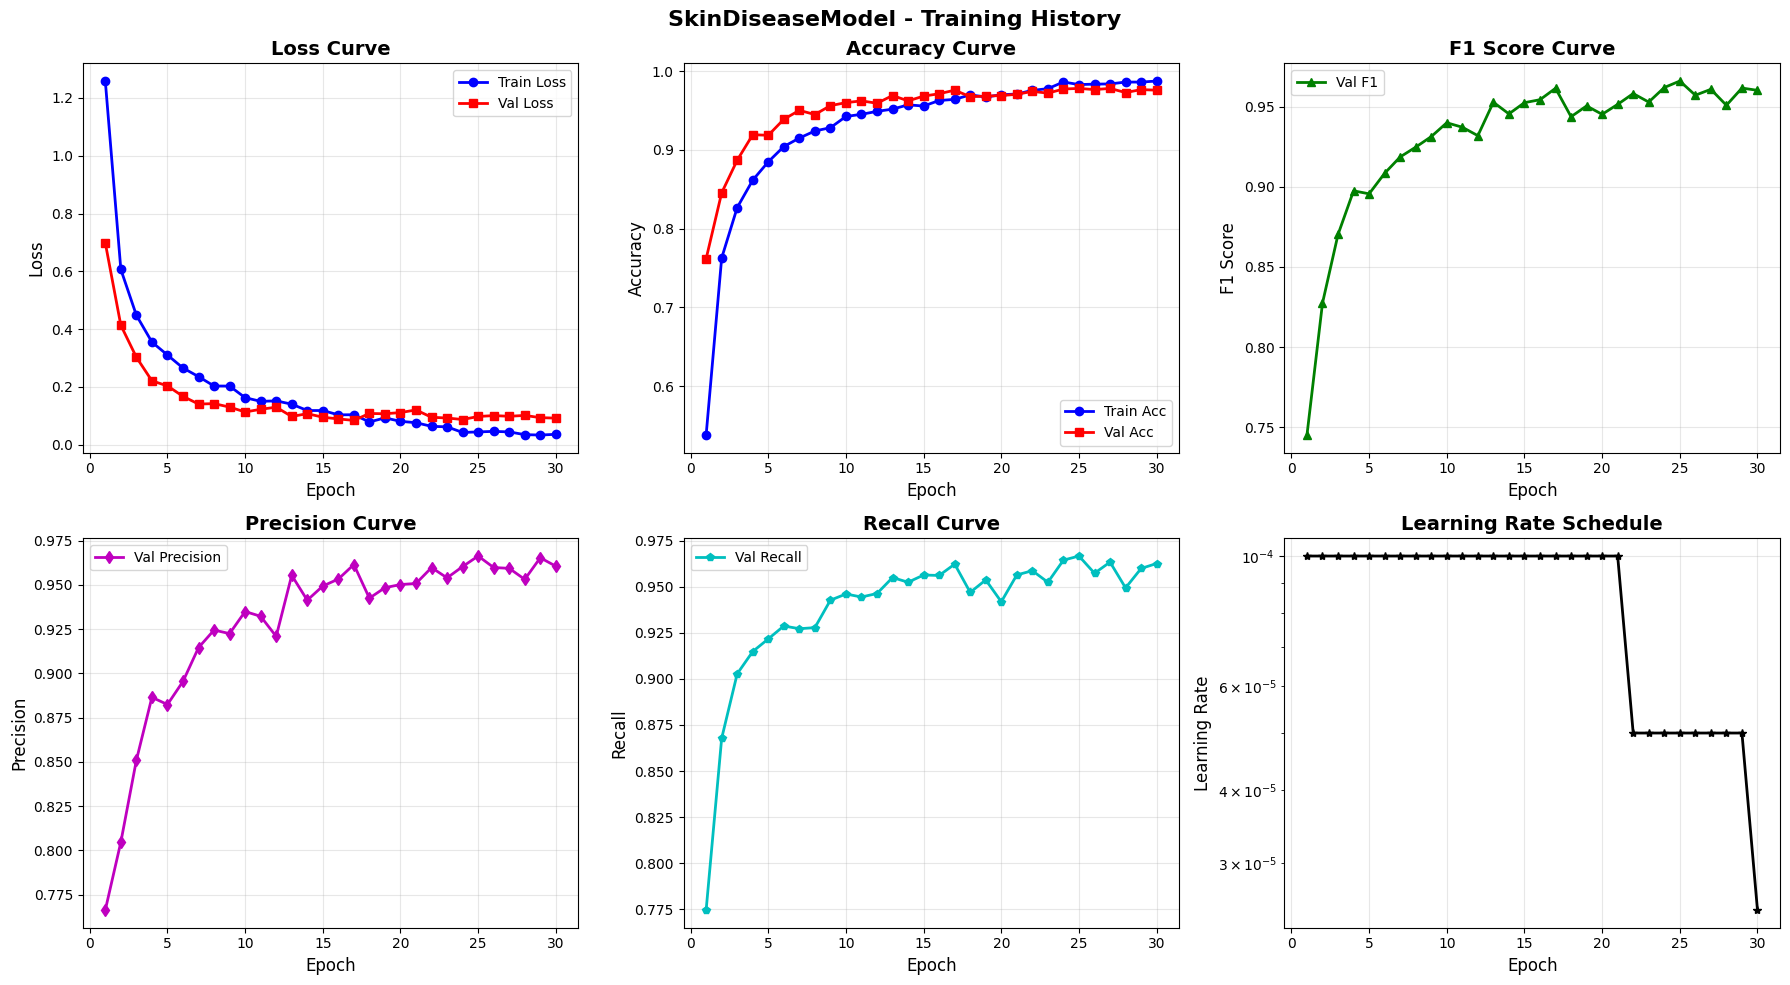

In [16]:
# ==================== PLOT TRAINING HISTORY ====================
plot_training_history(history, model_name="SkinDiseaseModel")



Evaluating on Validation Set


Evaluating Validation: 100%|██████████| 42/42 [00:06<00:00,  6.75it/s]



Validation Set Results:
Accuracy:          0.9781 (97.81%)
F1 Score (Macro):  0.9662
F1 Score (Weighted): 0.9782
Precision (Macro): 0.9663
Recall (Macro):    0.9666


Detailed Classification Report (Validation Set):
                         precision    recall  f1-score   support

      Actinic keratoses     0.9024    0.8605    0.8810        86
             Chickenpox     0.9910    0.9821    0.9865       112
                 Cowpox     0.9706    1.0000    0.9851        99
         Dermatofibroma     1.0000    0.9565    0.9778        23
                   HFMD     1.0000    0.9917    0.9958       241
                Healthy     0.9828    1.0000    0.9913       171
                Measles     1.0000    1.0000    1.0000        82
              Monkeypox     0.9953    0.9883    0.9918       426
Squamous cell carcinoma     0.8209    0.8871    0.8527        62
       Vascular lesions     1.0000    1.0000    1.0000        25

               accuracy                         0.9781      1327
 

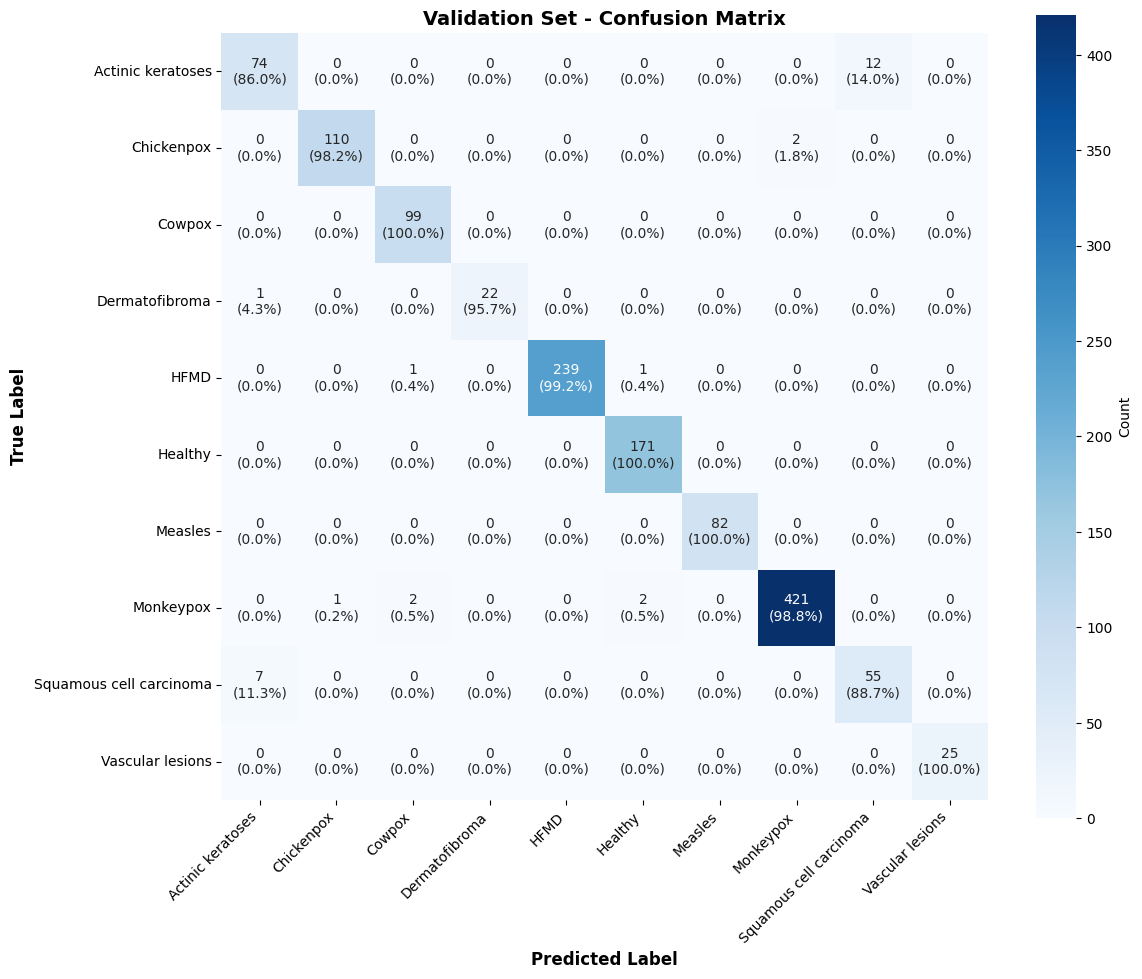

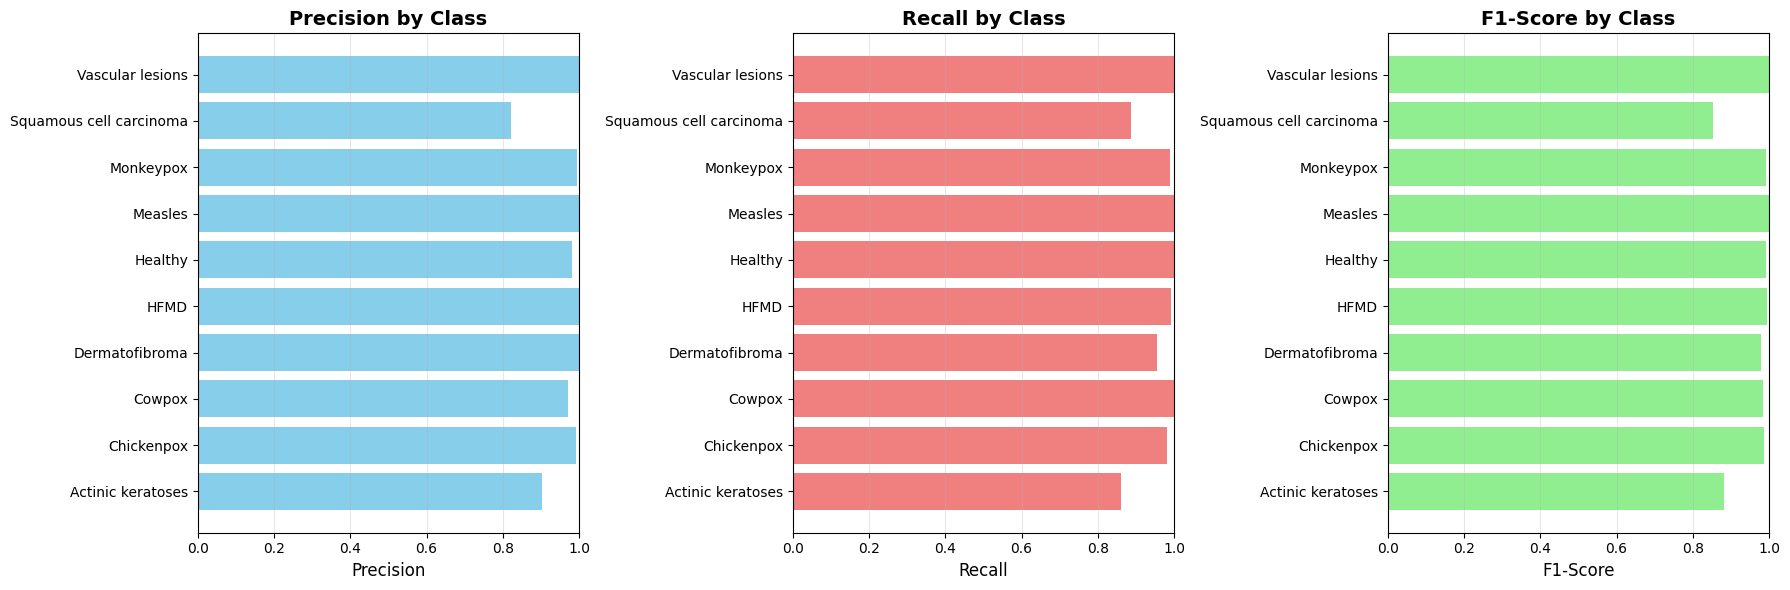


Per-Class Performance (Validation Set):
                  Class  Precision   Recall  F1-Score  Support
      Actinic keratoses   0.902439 0.860465  0.880952       86
             Chickenpox   0.990991 0.982143  0.986547      112
                 Cowpox   0.970588 1.000000  0.985075       99
         Dermatofibroma   1.000000 0.956522  0.977778       23
                   HFMD   1.000000 0.991701  0.995833      241
                Healthy   0.982759 1.000000  0.991304      171
                Measles   1.000000 1.000000  1.000000       82
              Monkeypox   0.995272 0.988263  0.991755      426
Squamous cell carcinoma   0.820896 0.887097  0.852713       62
       Vascular lesions   1.000000 1.000000  1.000000       25


In [17]:
# ==================== EVALUATE ON VALIDATION SET ====================
val_results = evaluate_model(model, val_loader, dataset_name="Validation")


Evaluating on Test Set


Evaluating Test: 100%|██████████| 42/42 [00:06<00:00,  6.93it/s]



Test Set Results:
Accuracy:          0.9783 (97.83%)
F1 Score (Macro):  0.9632
F1 Score (Weighted): 0.9783
Precision (Macro): 0.9678
Recall (Macro):    0.9594


Detailed Classification Report (Test Set):
                         precision    recall  f1-score   support

      Actinic keratoses     0.9121    0.9432    0.9274        88
             Chickenpox     0.9741    1.0000    0.9869       113
                 Cowpox     0.9899    0.9899    0.9899        99
         Dermatofibroma     0.9565    0.8800    0.9167        25
                   HFMD     1.0000    0.9835    0.9917       242
                Healthy     0.9884    0.9942    0.9913       171
                Measles     0.9762    0.9880    0.9820        83
              Monkeypox     0.9882    0.9859    0.9871       426
Squamous cell carcinoma     0.8923    0.9062    0.8992        64
       Vascular lesions     1.0000    0.9231    0.9600        26

               accuracy                         0.9783      1337
             

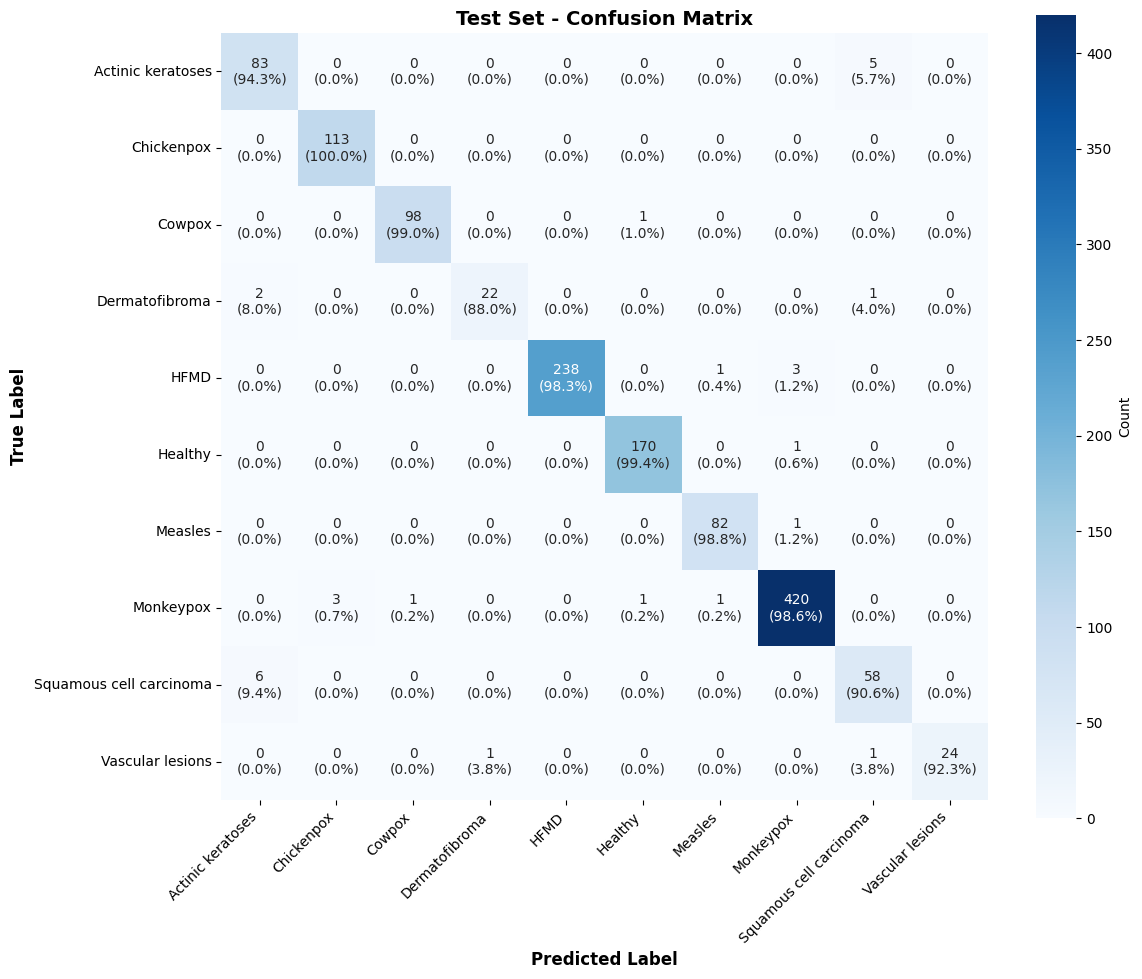

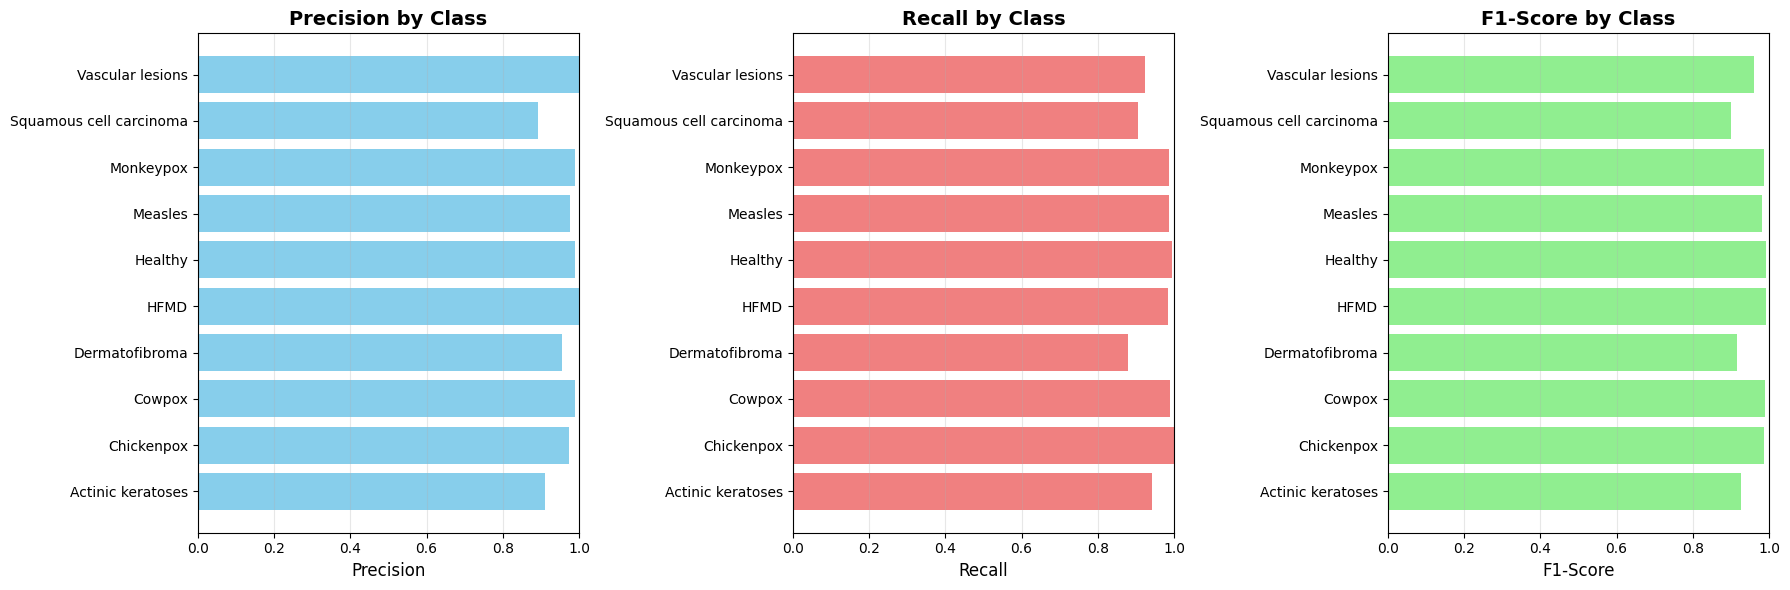


Per-Class Performance (Test Set):
                  Class  Precision   Recall  F1-Score  Support
      Actinic keratoses   0.912088 0.943182  0.927374       88
             Chickenpox   0.974138 1.000000  0.986900      113
                 Cowpox   0.989899 0.989899  0.989899       99
         Dermatofibroma   0.956522 0.880000  0.916667       25
                   HFMD   1.000000 0.983471  0.991667      242
                Healthy   0.988372 0.994152  0.991254      171
                Measles   0.976190 0.987952  0.982036       83
              Monkeypox   0.988235 0.985915  0.987074      426
Squamous cell carcinoma   0.892308 0.906250  0.899225       64
       Vascular lesions   1.000000 0.923077  0.960000       26


In [18]:
# ==================== EVALUATE ON TEST SET ====================
test_results = evaluate_model(model, test_loader, dataset_name="Test")

In [19]:
# ==================== SAVE FINAL RESULTS ====================
print("\n" + "="*70)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*70)
print(f"\nValidation Set:")
print(f"  Accuracy:  {val_results['accuracy']:.4f}")
print(f"  F1 Score:  {val_results['f1_macro']:.4f}")
print(f"\nTest Set:")
print(f"  Accuracy:  {test_results['accuracy']:.4f}")
print(f"  F1 Score:  {test_results['f1_macro']:.4f}")
print("="*70)

# Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'class_names': class_names,
    'num_classes': num_classes,
    'val_results': val_results,
    'test_results': test_results
}, 'final_skin_disease_model.pth')

print("\n✓ Model and results saved successfully!")
print("  - Model checkpoint: final_skin_disease_model.pth")
print("  - Training history plots saved")
print("  - Confusion matrices saved")
print("  - Performance charts saved")


FINAL MODEL PERFORMANCE SUMMARY

Validation Set:
  Accuracy:  0.9781
  F1 Score:  0.9662

Test Set:
  Accuracy:  0.9783
  F1 Score:  0.9632

✓ Model and results saved successfully!
  - Model checkpoint: final_skin_disease_model.pth
  - Training history plots saved
  - Confusion matrices saved
  - Performance charts saved
